In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import distanX

import cv2
import matplotlib.pyplot as plt

In [9]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_binned_outputs.tar.gz
!tar -xzvf Visium_HD_Mouse_Brain_binned_outputs.tar.gz

Note: To read visium HD SpaceRanger output directly, `pyarrow` and `fastparquet` are  demanded. 

In [3]:
tissue_position_df = pd.read_parquet('./binned_outputs/square_008um/spatial/tissue_positions.parquet')
tissue_position_df.to_csv('./binned_outputs/square_008um/spatial/tissue_positions_list.csv', index=False, header=None)

library_id = 'brain'

adata = sc.read_visium('./binned_outputs/square_008um', library_id=library_id)
adata.var_names_make_unique()

## load hand-drawn regions

We use line segments to approximate the regions' contours.  
For now we can adjust approximate precision only, on `epsilon_factor`.

In [4]:
c2l_i1 = distanX.Curve2Line()
img_ROI1 = './tissue_hires_image_ROI1_mask.png'

c2l_i1.load_and_preprocess(img_ROI1)
c2l_i1.detect_contours()
c2l_i1.approximate_contours(epsilon_factor=0.001)

True

Now let's take a glance at the ROI and the hand-drawn iamge.

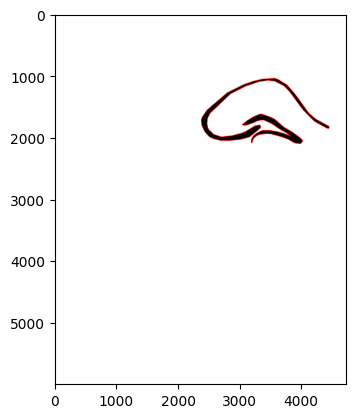

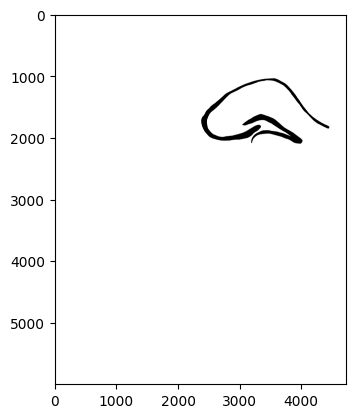

In [5]:
line_img = c2l_i1.image.copy()
for segment in c2l_i1.line_segments:
    cv2.polylines(line_img, [np.array(segment['points'])], True, (0, 0, 255), 10)
line_img = cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)

plt.imshow(line_img)
plt.show()
plt.imshow(c2l_i1.image)
plt.show()

## export hand-drawn regions to ROI in adata

In [6]:
l2r_i1 = distanX.Line2ROI()
l2r_i1.load_adata(adata)

It's necessary to match the scales of the hand_drawn image and the coordinate system of adata, like the images stored in adata.

You can set `image_path` only, and `Line2ROI.set_scalefactor` would find first library and scale factor of the hires image.  
Otherwise, you could set `override_scalefactor` parameter, which will overwrite the scale factor directly.

In [7]:
l2r_i1.set_scalefactor(image_path=img_ROI1, library_id=library_id, reference_image_key='hires')

Now name ROI 1, and add its information to adata, which would be in `adata.obs['ROI_'+name]` with values 'True' and 'False'.

In [8]:
ROI1_name = 'ROI1'

l2r_i1.append_polygons(c2l_i1.extract_polygons(),ROI1_name)
l2r_i1.set_adata_ROI(ROI1_name)

AnnData object with n_obs × n_vars = 393543 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'ROI_ROI1'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Now let's take a glance at the ROI again.

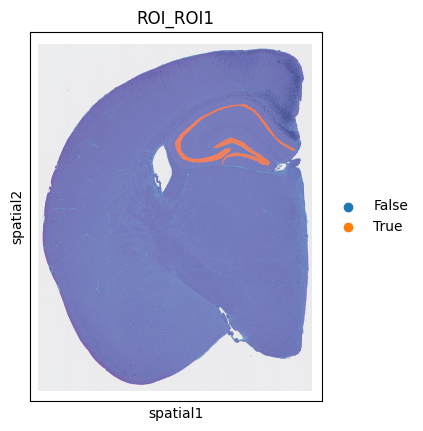

In [9]:
sc.pl.spatial(adata, color=['ROI_'+ROI1_name])

## add another ROI in blank area without spots

Now everything is ready to calculate group spatial distance, if you've got a group in `adata.obs` such as `adata.obs['celltype']`. But let's set another ROI in another way instead.

For some cases you may want ROI in blank area without spots, such as bronchi. Here we generate some artificial spots in ROI.

In [10]:
c2l_i2 = distanX.Curve2Line()
img_ROI2 = './tissue_hires_image_ROI2_mask.png'

c2l_i2.load_and_preprocess(img_ROI2)
c2l_i2.detect_contours()
c2l_i2.approximate_contours(epsilon_factor=0.001)

True

Note: The calculattion of distance matrix support parallel. You can set `n_jobs` when instantiate.

In [13]:
cd = distanX.CloudDistance(n_jobs=10)

In [14]:
cd.set_artificial_ROI(polygons=c2l_i2.extract_polygons(), img_width=c2l_i2.image.shape[1], img_height=c2l_i2.image.shape[0], class_name='class_2', scale_factor=l2r_i1.scalefactor,density=1000)

## calculate group spatial distance

The default method of calculating distance between two points is Euclidean distance, which can be replaced.

Here is a example of how to set a distance calculation function (but still Euclidean).

In [15]:
def pp_distance_function(x1: float, y1: float, x2: float, y2: float) -> float:
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

cd.set_pp_distance_function(pp_distance_function)

Now calculate the distance matrix, rownames are 1st group and colnames are 2nd group as set in parameters.  
Note that one `class_name` will be set as 'True' if it's not set and is None, which stand for the ROI.

And for the artificial ROI, you can set `class_name` as 'class_1' or 'class_2', which matches above.

**Otherwise, you could calculate distance from a defined group to ROI, between 2 defined groups, etc. Like follow:**
```python
cd.compute_distance_matrix(adata,class_key_1='celltype',class_name_1='Neuron',class_key_2='ROI_ROI1',class_name_2='True')
```

In [17]:
cd.compute_distance_matrix(adata,class_key_1='ROI_ROI1',class_name_1='True',class_name_2='class_2')

,artificial_222717,artificial_222718,artificial_222719,artificial_222720,artificial_222721,artificial_222722,artificial_222723,artificial_222724,artificial_222725,artificial_222726,...,artificial_343912,artificial_343913,artificial_343914,artificial_343915,artificial_343916,artificial_343917,artificial_344903,artificial_344904,artificial_344905,artificial_344906
s_008um_00255_00386-1,4374.698139,4390.638257,4406.601718,4422.588270,4438.597662,4454.629648,4470.683986,4486.760435,4502.858758,4518.978723,...,7392.691959,7411.533269,7430.374843,7449.216677,7468.058771,7486.901122,7224.989860,7243.823879,7262.658204,7281.492834
s_008um_00261_00228-1,2626.758589,2620.143171,2613.647583,2607.272721,2601.019472,2594.888715,2588.881321,2582.998150,2577.240054,2571.607872,...,2791.508413,2810.163567,2828.821880,2847.483290,2866.147735,2884.815158,2627.919997,2646.514399,2665.113003,2683.715721
s_008um_00261_00300-1,2752.609346,2760.723383,2768.942556,2777.265933,2785.692579,2794.221561,2802.851943,2811.582792,2820.413175,2829.342161,...,4875.972086,4894.798226,4913.624880,4932.452042,4951.279706,4970.107868,4708.714846,4727.527502,4746.340798,4765.154726
s_008um_00256_00247-1,2349.331016,2346.421475,2343.660631,2341.049010,2338.587112,2336.275411,2334.114352,2332.104355,2330.245810,2328.539081,...,3363.633516,3382.244588,3400.858769,3419.476010,3438.096261,3456.719474,3200.724185,3219.279147,3237.838020,3256.400737
s_008um_00241_00396-1,4437.011421,4453.993182,4470.990280,4488.002541,4505.029792,4522.071864,4539.128590,4556.199806,4573.285350,4590.385061,...,7729.336343,7748.085939,7766.836231,7785.587214,7804.338882,7823.091231,7563.678046,7582.413594,7601.149922,7619.887024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_008um_00254_00240-1,2330.275773,2325.689493,2321.247931,2316.951919,2312.802268,2308.799768,2304.945185,2301.239263,2297.682720,2294.276252,...,3175.209976,3193.714973,3212.224490,3230.738447,3249.256770,3267.779383,3014.088950,3032.517772,3050.952274,3069.392354
s_008um_00272_00330-1,3487.074730,3498.191590,3509.374949,3520.624173,3531.938632,3543.317701,3554.760761,3566.267194,3577.836390,3589.467741,...,5730.315157,5749.206600,5768.098055,5786.989520,5805.880996,5824.772483,5560.674047,5579.564095,5598.454164,5617.344253
s_008um_00246_00221-1,2309.342428,2300.190251,2291.157314,2282.245031,2273.454821,2264.788107,2256.246310,2247.830856,2239.543168,2231.384670,...,2706.736797,2724.600399,2742.477800,2760.368731,2778.272931,2796.190145,2555.054942,2572.723053,2590.408453,2608.110791
s_008um_00234_00299-1,2057.018501,2067.704802,2078.507899,2089.425979,2100.457250,2111.599937,2122.852286,2134.212563,2145.679054,2157.250064,...,4987.666554,5006.007011,5024.351564,5042.700167,5061.052777,5079.409351,4828.813411,4847.092159,4865.375601,4883.663684


Also, the method of calculating distance between a point in a class and all points in another class could be customized. the customized function should work on a 1d array, as it's expected to run on each row of the distance matrix.

The default method is for every point in the class set in `on` parameter in `CloudDistance.compute_cloud_distance`, find the minimal distance to another class.  
Anyway let's set it again.

In [18]:
cd.set_cloud_distance_function('min')
# equal to
# cd.set_cloud_distance_function(np.min)

Set `on` as 'class_1' makes the funtion find min of each row. That means the minimal distances from each point in class 1 to the whole class 2. This return an array with same size of class 1.

In [19]:
distances = cd.compute_cloud_distance(on='class_1')

We can visualize the result. Most distances range 700px to 1100px.

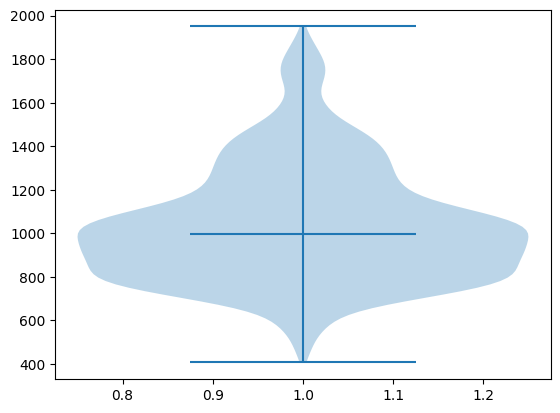

In [20]:
plt.violinplot(distances, showmedians=True)
plt.show()

And the mean minimal distance.

In [21]:
np.mean(distances)

np.float64(1037.6312950021984)